# Extract Data from MYSQL

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT *
FROM   (SELECT film_id,
               language_id,
               length,
               rating,
               special_features,
               rental_rate,
               rental_duration,
               replacement_cost,
               category_id
        FROM   rental r
               INNER JOIN inventory i using (inventory_id)
               INNER JOIN film f using (film_id)
               INNER JOIN film_category fc using (film_id)
        WHERE  Year(rental_date) = 2005
        GROUP  BY film_id,
                  language_id,
                  length,
                  rating,
                  special_features,
                  rental_rate,
                  category_id
        HAVING Count(*) > 1) AS query_1
       INNER JOIN (SELECT film_id,
                          Max(rented_may_2005) AS rented_may_2005
                   FROM   (SELECT film_id,
                                  CASE
                                    WHEN Month(rental_date) = 5
                                         AND Year(rental_date) = 2005 THEN 1
                                    ELSE 0
                                  END AS 'rented_may_2005'
                           FROM   rental r
                                  INNER JOIN inventory i using (inventory_id)
                                  INNER JOIN film f using (film_id)) AS
                          rented_may_2005
                   GROUP  BY film_id) AS query_2 using (film_id);'''

df_filmfeat = pd.read_sql_query(query, engine)
df_filmfeat.head()

,film_id,language_id,length,rating,special_features,rental_rate,rental_duration,replacement_cost,category_id,rented_may_2005
0,19,1,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,6,20.99,1,1
1,21,1,129,R,"Commentaries,Behind the Scenes",4.99,3,17.99,1,1
2,29,1,168,NC-17,"Trailers,Commentaries,Deleted Scenes",2.99,5,11.99,1,1
3,56,1,129,G,"Trailers,Commentaries",2.99,6,15.99,1,1
4,67,1,77,PG-13,Deleted Scenes,2.99,5,24.99,1,1


# EDA

<AxesSubplot:xlabel='rental_rate', ylabel='count'>

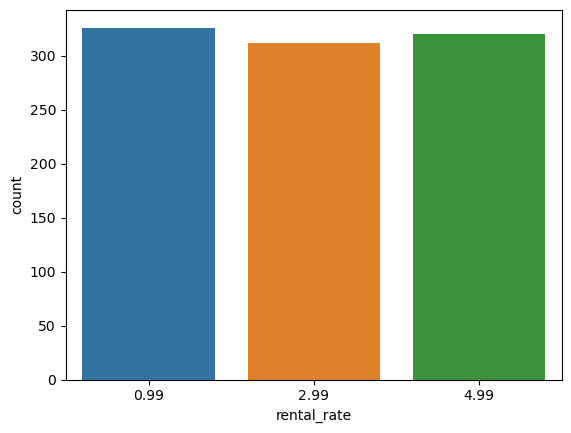

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Rental Rate as categorical Variable
sns.countplot(x=df_filmfeat.rental_rate)

<AxesSubplot:xlabel='rating', ylabel='count'>

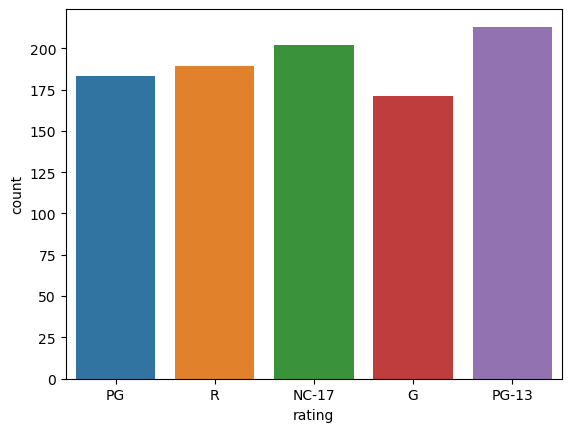

In [5]:
# Rating
sns.countplot(x=df_filmfeat.rating)

<AxesSubplot:xlabel='language_id', ylabel='count'>

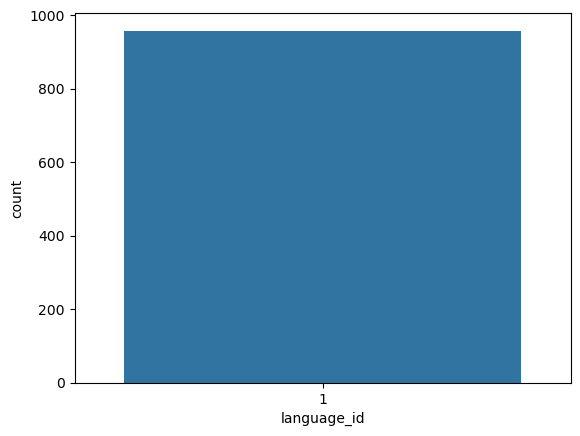

In [6]:
# Only 1 Language. dropping it
sns.countplot(x=df_filmfeat.language_id)

In [7]:
df_filmfeat.drop('language_id', axis=1, inplace=True)

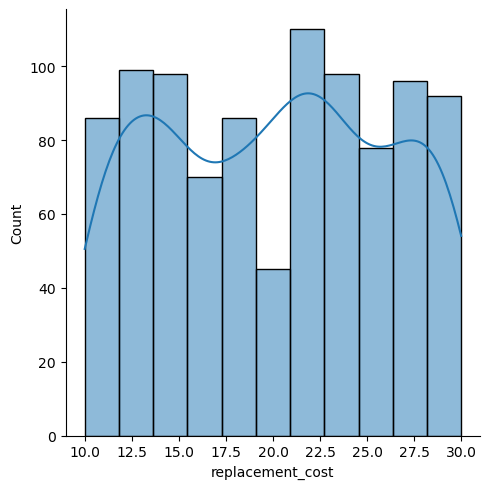

In [8]:
# Replacement Cost - (Will be treated as numeric only - even though it appears as discrete / categorical)
sns.displot(df_filmfeat['replacement_cost'],kde=True)
plt.show()

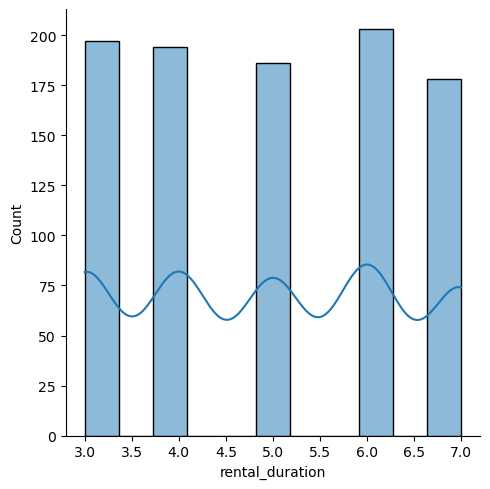

In [9]:
# Rental Duration (Will be treated as numeric only - even though it appears as discrete / categorical)
sns.displot(df_filmfeat['rental_duration'],kde=True)
plt.show()

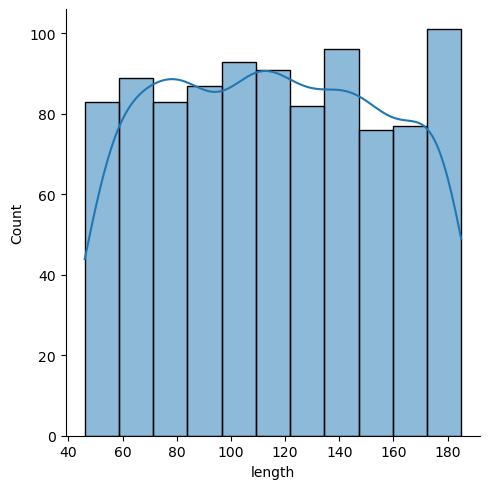

In [10]:
# Length
sns.displot(df_filmfeat['length'],kde=True)
plt.show()

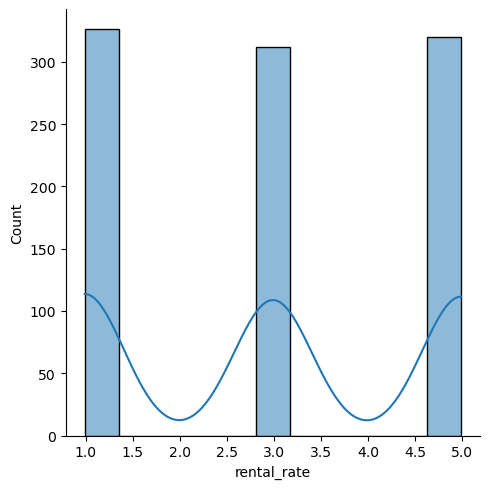

In [11]:
# Rental Rate (Will be treated as numeric only - even though it appears as discrete / categorical)
sns.displot(df_filmfeat['rental_rate'],kde=True)
plt.show()

# Transforming Special Features

In [12]:
# Transforming Special Features:

special_features=[]
for x in df_filmfeat['special_features'].value_counts().index:
    for y in x.split(","):
        special_features.append(y)

def transform_spl_feat(df):
    for col in list(set(special_features)):
        df[col]=0

    for col in list(set(special_features)):
        df[col]=df['special_features'].apply(lambda x: 1 if col in x.split(",") else 0)
        
    return df
    
df_filmfeat=transform_spl_feat(df_filmfeat)
df_filmfeat.head()

,film_id,length,rating,special_features,rental_rate,rental_duration,replacement_cost,category_id,rented_may_2005,Behind the Scenes,Trailers,Commentaries,Deleted Scenes
0,19,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,6,20.99,1,1,1,0,1,1
1,21,129,R,"Commentaries,Behind the Scenes",4.99,3,17.99,1,1,1,0,1,0
2,29,168,NC-17,"Trailers,Commentaries,Deleted Scenes",2.99,5,11.99,1,1,0,1,1,1
3,56,129,G,"Trailers,Commentaries",2.99,6,15.99,1,1,0,1,1,0
4,67,77,PG-13,Deleted Scenes,2.99,5,24.99,1,1,0,0,0,1


In [13]:
# Checking for NAs
df_filmfeat.isna().sum()

film_id              0
length               0
rating               0
special_features     0
rental_rate          0
rental_duration      0
replacement_cost     0
category_id          0
rented_may_2005      0
Behind the Scenes    0
Trailers             0
Commentaries         0
Deleted Scenes       0
dtype: int64

# Train-Test Split and Scaling the DataFrame

In [14]:
# Normalization of the columns

import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Some restructuring of the DF before proceeding for normalization
df_filmfeat.drop('film_id', axis=1, inplace=True)
df_filmfeat.drop('special_features', axis=1, inplace=True)

df_filmfeat['category_id'] = df_filmfeat['category_id'].astype('object')
df_filmfeat['rental_rate'] = df_filmfeat['rental_rate'].astype('object')

y = df_filmfeat['rented_may_2005']
X = df_filmfeat.drop('rented_may_2005', axis=1)

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=151)

# Selecting the numeric columns
X_train_num = X_train.select_dtypes(include = np.number)

# Applying transformer on numeric Train data
transformer = MinMaxScaler().fit(X_train_num)
X_train_normalized = transformer.transform(X_train_num)
X_train_normalized = pd.DataFrame(X_train_normalized,columns=X_train_num.columns)
X_train_normalized.head()

,length,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,Deleted Scenes
0,0.453237,1.0,0.20,1.0,0.0,1.0,1.0
1,0.129496,0.5,0.15,1.0,1.0,0.0,1.0
2,0.482014,0.0,0.35,1.0,1.0,1.0,1.0
3,0.942446,1.0,0.85,0.0,0.0,0.0,1.0
4,0.956835,0.0,0.05,1.0,0.0,0.0,0.0


In [16]:
# Scaling categorical data
X_train_categorical = X_train.select_dtypes(include = object)

encoder = OneHotEncoder().fit(X_train_categorical)
encoded = encoder.transform(X_train_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_categorical.columns)
onehot_encoded_train = pd.DataFrame(encoded, columns=cols)
onehot_encoded_train.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,category_id_1,category_id_2,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Concatenating Scaled Numeric and Categorical Columns
X_train_transformed = pd.concat([X_train_normalized, onehot_encoded_train], axis=1)
X_train_transformed.head()

,length,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,Deleted Scenes,rating_G,rating_NC-17,rating_PG,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.453237,1.0,0.20,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.129496,0.5,0.15,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.482014,0.0,0.35,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.942446,1.0,0.85,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.956835,0.0,0.05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Regular check of NAs and shape of DF after every concatenation
display(X_train_transformed.isna().sum())
display(X_train_transformed.shape)

length               0
rental_duration      0
replacement_cost     0
Behind the Scenes    0
Trailers             0
Commentaries         0
Deleted Scenes       0
rating_G             0
rating_NC-17         0
rating_PG            0
rating_PG-13         0
rating_R             0
rental_rate_0.99     0
rental_rate_2.99     0
rental_rate_4.99     0
category_id_1        0
category_id_2        0
category_id_3        0
category_id_4        0
category_id_5        0
category_id_6        0
category_id_7        0
category_id_8        0
category_id_9        0
category_id_10       0
category_id_11       0
category_id_12       0
category_id_13       0
category_id_14       0
category_id_15       0
category_id_16       0
dtype: int64

(766, 31)

# Check for Multicollinearity and drop negative correlated columns

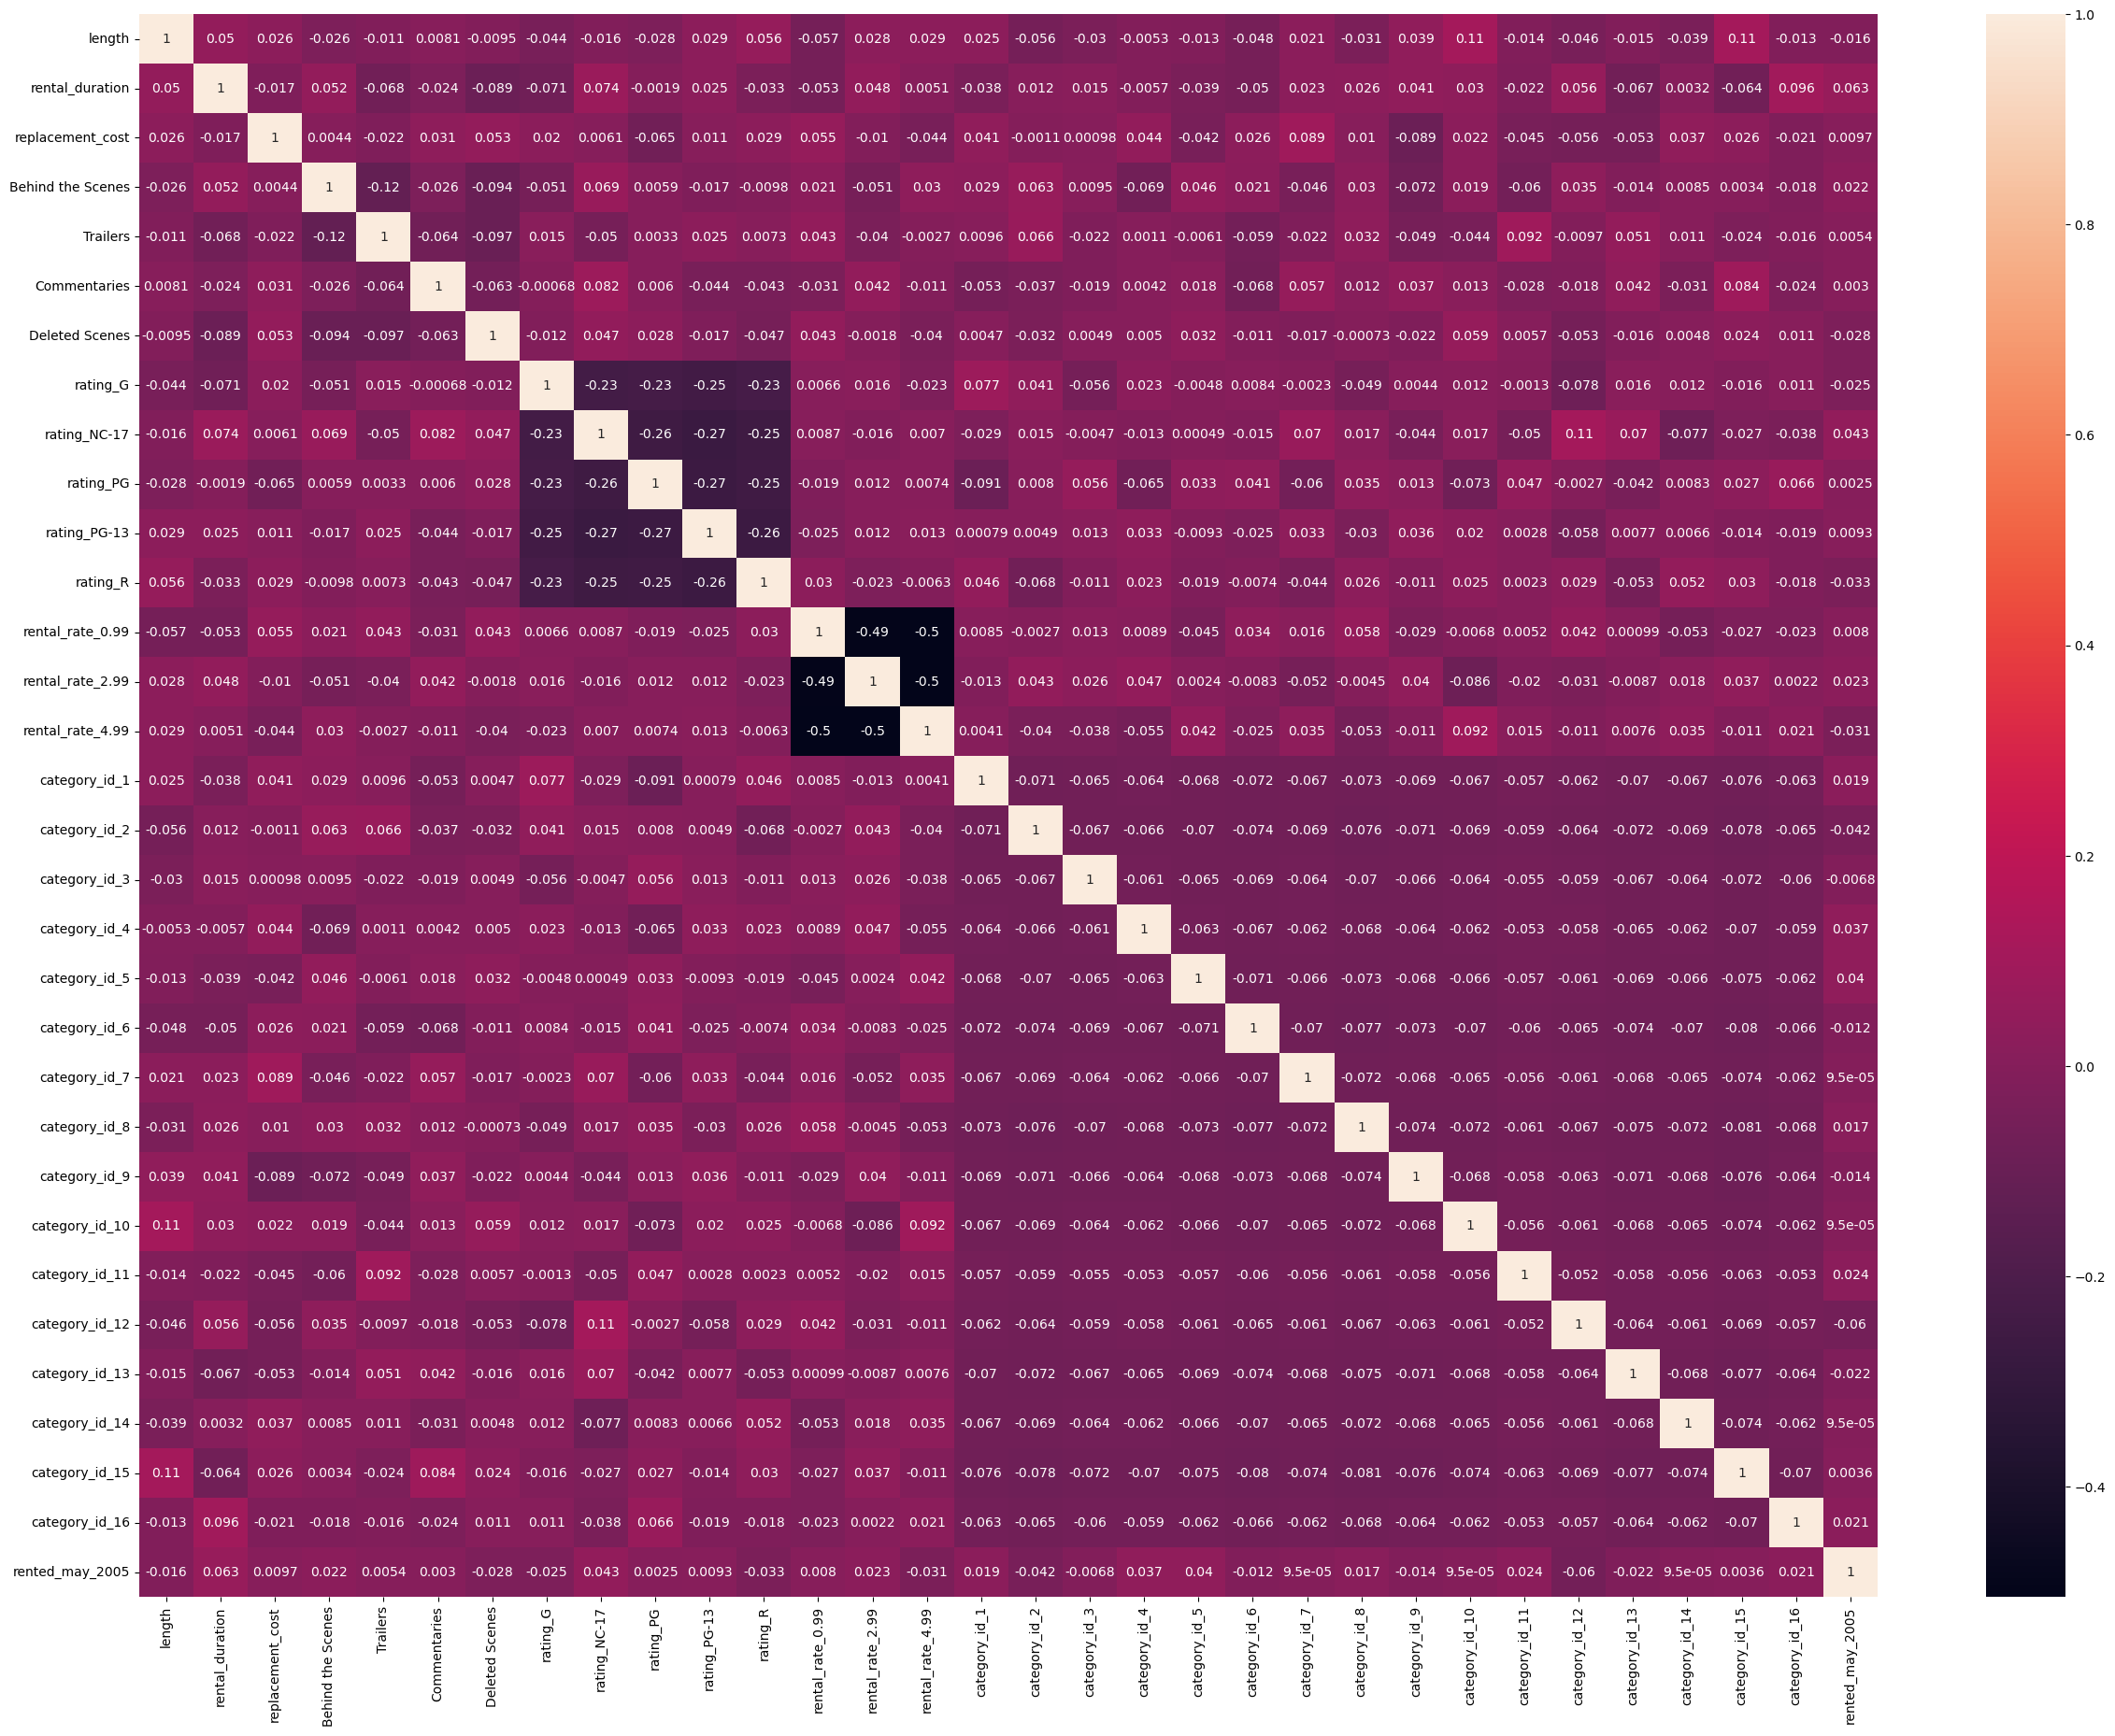

In [19]:
# Check for multicollinearity from the heatmap.
X_train_transformed
corr_matrix=pd.concat([X_train_transformed,y],axis=1).corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(30, 22))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [20]:
#  If none of the correlated input features are present, find all the features having negative correlation and drop them
drop_cols=list(corr_matrix[corr_matrix['rented_may_2005']<0].index)
print(drop_cols)

# Drop selected columns from above
for col in drop_cols:
    X_train_transformed.drop(col, axis=1, inplace=True)
    
X_train_transformed.head()

['length', 'Deleted Scenes', 'rating_G', 'rating_R', 'rental_rate_4.99', 'category_id_2', 'category_id_3', 'category_id_6', 'category_id_9', 'category_id_12', 'category_id_13']


,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,rating_NC-17,rating_PG,rating_PG-13,rental_rate_0.99,rental_rate_2.99,category_id_1,category_id_4,category_id_5,category_id_7,category_id_8,category_id_10,category_id_11,category_id_14,category_id_15,category_id_16
0,1.0,0.20,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.15,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.35,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Building Logisitic Regression Model

In [21]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [22]:
'''
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)
'''

"\nclassification = LogisticRegression(random_state=0, solver='saga',\n                  multi_class='multinomial').fit(X_train_transformed, y_train)\n"

# Scaling Test Data

In [23]:
# Scaling numeric Test data
X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_normalized = pd.DataFrame(X_test_normalized,columns=X_test_num.columns)

In [24]:
# Scaling categorical Test data
X_test_categorical = X_test.select_dtypes(include = object)

encoder = OneHotEncoder().fit(X_test_categorical)
encoded = encoder.transform(X_test_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_test_categorical.columns)
onehot_encoded_test = pd.DataFrame(encoded, columns=cols)

In [25]:
# Concatenating Numeric and Categorical Columns
X_test_transformed = pd.concat([X_test_normalized, onehot_encoded_test], axis=1)

# Dropping the negative correlation columns:
for col in drop_cols:
    X_test_transformed.drop(col, axis=1, inplace=True)
X_test_transformed  

X_test_transformed.head()

,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,rating_NC-17,rating_PG,rating_PG-13,rental_rate_0.99,rental_rate_2.99,category_id_1,category_id_4,category_id_5,category_id_7,category_id_8,category_id_10,category_id_11,category_id_14,category_id_15,category_id_16
0,0.75,0.65,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.25,0.90,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.75,0.95,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.75,0.05,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.00,0.10,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Predicting the test set on generated LR model

In [26]:
# Predictions on the test set:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.6875

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  0,  60],
       [  0, 132]], dtype=int64)

In [28]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# Identify the Imbalance of output variable

In [29]:
y_train.value_counts()

1    554
0    212
Name: rented_may_2005, dtype: int64

In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pred = classification.predict(X_test_transformed)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))


precision:  0.6875
recall:  1.0
f1:  0.8148148148148148


In [31]:
# Create Over Sampling

In [32]:
from sklearn.utils import resample
pd.DataFrame(y_train).reset_index()
train=pd.concat([X_train_transformed,pd.DataFrame(y_train).reset_index().drop('index', axis=1)],axis=1)

In [33]:
train

,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,rating_NC-17,rating_PG,rating_PG-13,rental_rate_0.99,rental_rate_2.99,...,category_id_4,category_id_5,category_id_7,category_id_8,category_id_10,category_id_11,category_id_14,category_id_15,category_id_16,rented_may_2005
0,1.0,0.20,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.5,0.15,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.35,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.5,0.55,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
762,1.0,0.90,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
763,0.5,0.55,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
764,1.0,1.00,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [34]:
# Regular check of NAs and shape of DF after every concatenation
display(train.isna().sum())
display(train.shape)

rental_duration      0
replacement_cost     0
Behind the Scenes    0
Trailers             0
Commentaries         0
rating_NC-17         0
rating_PG            0
rating_PG-13         0
rental_rate_0.99     0
rental_rate_2.99     0
category_id_1        0
category_id_4        0
category_id_5        0
category_id_7        0
category_id_8        0
category_id_10       0
category_id_11       0
category_id_14       0
category_id_15       0
category_id_16       0
rented_may_2005      0
dtype: int64

(766, 21)

In [35]:
# separate majority/minority classes
no_rented_may_2005 = train[train['rented_may_2005']==0]
yes_rented_may_2005 = train[train['rented_may_2005']==1]

In [36]:
# Check Shape
display(no_rented_may_2005.shape)
display(yes_rented_may_2005.shape)

(212, 21)

(554, 21)

In [37]:
no_rented_may_2005

,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,rating_NC-17,rating_PG,rating_PG-13,rental_rate_0.99,rental_rate_2.99,...,category_id_4,category_id_5,category_id_7,category_id_8,category_id_10,category_id_11,category_id_14,category_id_15,category_id_16,rented_may_2005
6,0.50,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,1.00,0.15,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
12,1.00,0.85,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13,0.25,0.70,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14,0.25,0.95,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.50,0.85,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
752,0.00,0.40,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
755,0.25,0.40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
761,0.50,0.55,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
# oversample minority
no_rented_may_2005_oversampled = resample(no_rented_may_2005, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(yes_rented_may_2005),#<- make both sets the same size
                                    random_state=0)

In [39]:
# Check shape of oversampled DF and display the rows
display(no_rented_may_2005_oversampled.shape)
display(yes_rented_may_2005.shape)
no_rented_may_2005_oversampled.head()

(554, 21)

(554, 21)

,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,rating_NC-17,rating_PG,rating_PG-13,rental_rate_0.99,rental_rate_2.99,...,category_id_4,category_id_5,category_id_7,category_id_8,category_id_10,category_id_11,category_id_14,category_id_15,category_id_16,rented_may_2005
625,0.00,0.50,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
189,0.50,0.40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
442,0.00,0.40,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
704,0.75,0.90,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
246,1.00,0.85,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [40]:
train_oversampled = pd.concat([yes_rented_may_2005,no_rented_may_2005_oversampled],axis=0)
train_oversampled.head()

,rental_duration,replacement_cost,Behind the Scenes,Trailers,Commentaries,rating_NC-17,rating_PG,rating_PG-13,rental_rate_0.99,rental_rate_2.99,...,category_id_4,category_id_5,category_id_7,category_id_8,category_id_10,category_id_11,category_id_14,category_id_15,category_id_16,rented_may_2005
0,1.0,0.20,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.5,0.15,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.35,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [41]:
y_train_over = train_oversampled['rented_may_2005'].copy()
X_train_over = train_oversampled.drop('rented_may_2005',axis = 1).copy()

In [42]:
display(X_train_over.shape)
display(X_test_transformed.shape)

(1108, 20)

(192, 20)

In [43]:
X_train_over.columns==X_test_transformed.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [45]:
# Develop model from oversampled training data
LR_over = LogisticRegression(random_state=0, solver='lbfgs')
LR_over.fit(X_train_over, y_train_over)
pred = LR_over.predict(X_test_transformed)

predictions = classification.predict(X_test_transformed)
print("Test Score: ",classification.score(X_test_transformed, y_test))
print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

Test Score:  0.6875
precision:  0.7395833333333334
recall:  0.5378787878787878
f1:  0.6228070175438597
